## **Problem Definition**
### **Context**
Image recognition is a critical aspect of numerous applications. From medical imaging diagnosis in healthcare to facial recognition in security and surveillance, the popularity of image recognition algorithms has grown drastically in the past decade and demand keeps expanding. As more industries rely on the ability to automatically identify, classify, and interpret visual data, finding the most reliable deep learning architectures to address specific tasks becomes increasingly important.

One particularly challenging area is facial emotion recognition (FER). The subtleness of facial expressions, coupled with intra-class variability and inter-class similarity, are testing features of human expression for machine learning algorithms. Literature reviews such as the one done by professor Z. Zang in "Facial Expression Recognition: A Review of Trends and Techniques", highlight the challenges of FER for machine learning techniques. They can range from features relating to the quality of the data such as occlusion and illumination variations, to more intrinsic characteristics of human expression such as the influence of cultural differences on facial expressions.

### **Objective**
The goal of this project is to apply a variety of deep learning techniques to determine the most efficient and reliable solution in facial emotion recognition.

### **About the dataset**
The data set consists of 2 folders, i.e., 'test', 'train'. Each of these folders has 6 subfolders:

* **‘happy’**: Images of people who have happy facial expressions.
* **‘sad’**: Images of people with sad or upset facial expressions.
* **‘surprise’**: Images of people who have shocked or surprised facial expressions.
* **‘neutral’**: Images of people showing no prominent emotion in their facial expression at all.
* **'angry'**: Images of people who have angry facial expressions.
* **'fear'**: Images of people who have fearfull expressions.

## **Importing the Libraries**

In [20]:
# Importing Libraries
import zipfile
import os

import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, models, regularizers, backend
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.vgg16 import VGG16

## **Function definitions**

In [2]:
# Function to delete all image files in a given directory and the directory itself 
def delete_files(directory_path):
    # Iterate through all files in the directory and delete them
    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)
    
        # Check if it's a file (and not a subdirectory) before deleting
        if os.path.isfile(file_path):
            os.remove(file_path)
        
    # After deleting all files, remove the directory itself
    os.rmdir(directory_path)

In [3]:
# Function to count all files inside a given dataset (i.g. train, test)
# Returns a dictionary with counts
def count_files(labels, directory_path):
    # Dictionary to store file counts
    file_counts = {}
    # Iterate through each subdirectory and count all files
    for label in labels:
        file_count = len([f for f in os.listdir(os.path.join(directory_path, label)) if os.path.isfile(os.path.join(directory_path,label, f))])
        file_counts[label] = file_count

    return file_counts

In [4]:
# Function to help convert 1 channel images into 3 channels
# Image from flow_from_directory() 
def preprocess_to_rgb(image):
    # Ensure the image is a TensorFlow tensor
    image_tensor = tf.convert_to_tensor(image)

    # Check if the image has only one channel
    if len(image_tensor.shape) == 3 and image_tensor.shape[-1] == 1:
        # Convert grayscale to RGB
        image_tensor = tf.image.grayscale_to_rgb(image_tensor)
    
    return image_tensor

In [5]:
# Function to display images from directory
# Takes directory path as parameter, set to display 3 images as default
def display_image(directory_path, target_size=(128, 128), num_images = 3):
    # Get a list of image files
    image_files = [file for file in os.listdir(directory_path) if file.lower().endswith(('png', 'jpg', 'jpeg'))]
    # Case there are no images in the folder
    if not image_files:
        print("No image files in the directory!")
        return
    
    # Limit to the requested number of images
    image_files = image_files[:num_images]

    # Display the images
    plt.figure(figsize=(15, 5))
    for i, image_file in enumerate(image_files):
        # Load and preprocess the image
        image_path = os.path.join(directory_path, image_file)
        image = load_img(image_path, target_size=target_size)
        image_array = img_to_array(image)

        # Plot the image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image_array.astype('uint8'))
        plt.axis('off')
        plt.title(image_file)
    
    plt.suptitle('Images from Directory')
    plt.tight_layout()
    plt.show()

In [6]:
# Function to plot training accuracy
# Takes model history as a parameter
def plot_training_history(history):
    # Extract accuracy and validation accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    
    # Plot the graph
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

## **Extracting Data**

In [7]:
# Recursively list all directories and files
for root, dirs, files in os.walk(os.getcwd()):
    print("Data directory:", root)
    print("Subdirectories:", dirs)

Data directory: C:\Users\gbisc\Documents\FER
Subdirectories: ['.ipynb_checkpoints', 'Data']
Data directory: C:\Users\gbisc\Documents\FER\.ipynb_checkpoints
Subdirectories: []
Data directory: C:\Users\gbisc\Documents\FER\Data
Subdirectories: ['test', 'train']
Data directory: C:\Users\gbisc\Documents\FER\Data\test
Subdirectories: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Data directory: C:\Users\gbisc\Documents\FER\Data\test\angry
Subdirectories: []
Data directory: C:\Users\gbisc\Documents\FER\Data\test\fear
Subdirectories: ['.ipynb_checkpoints']
Data directory: C:\Users\gbisc\Documents\FER\Data\test\fear\.ipynb_checkpoints
Subdirectories: []
Data directory: C:\Users\gbisc\Documents\FER\Data\test\happy
Subdirectories: []
Data directory: C:\Users\gbisc\Documents\FER\Data\test\neutral
Subdirectories: []
Data directory: C:\Users\gbisc\Documents\FER\Data\test\sad
Subdirectories: []
Data directory: C:\Users\gbisc\Documents\FER\Data\test\surprise
Subdirectories: []
Data director

In [5]:
# Path to file at local directory
path_to_zip_file = os.getcwd()

# Create the directory if it doesn't exist
os.makedirs(path_to_zip_file + '/Data', exist_ok=True)

# Extract data
with zipfile.ZipFile(path_to_zip_file + '/Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall(path_to_zip_file + '/Data')

## **Data Exploration**

In this section we are going to be exploring our data files

In [9]:
# Asssign lable to variable
labels = [d for d in os.listdir(path_to_zip_file + '/Data'+'/train') if os.path.isdir(os.path.join(path_to_zip_file,'Data','train', d))]
print(labels)

['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [10]:
# Find number of files stored in test and train
print("File counts in train directory:", count_files(labels,os.path.join(path_to_zip_file, 'Data','train')))
print("File counts in test directory:", count_files(labels,os.path.join(path_to_zip_file, 'Data','test')))

File counts in train directory: {'angry': 3995, 'fear': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprise': 3171}
File counts in test directory: {'angry': 958, 'fear': 1024, 'happy': 1774, 'neutral': 1233, 'sad': 1247, 'surprise': 831}


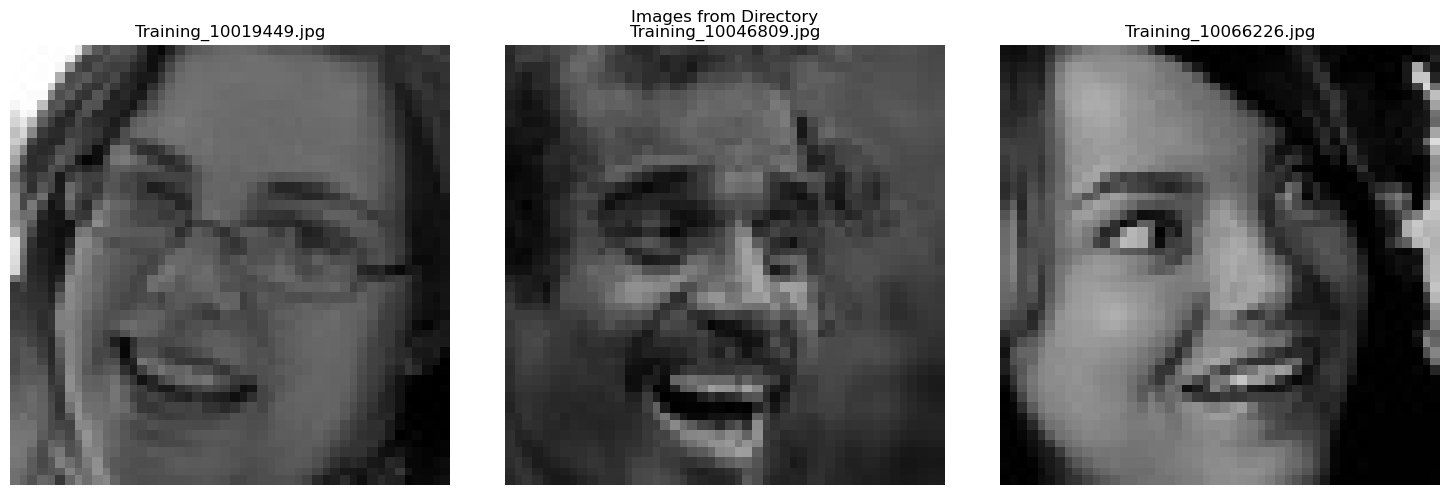

In [11]:
# Display data
display_image(os.path.join(path_to_zip_file, 'Data','train','happy'), target_size=(128, 128))

## **Data Loading**

In this section we are going to be loading the data for training. We are going to be using data augumentation features to improve the variety in our dataset.

In [12]:
# Set image parameters
img_height = 128
img_width = 128
batch_size = 32

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,       # Rotate images by up to 30 degrees
    width_shift_range=0.2,   # Shift images horizontally
    height_shift_range=0.2,  # Shift images vertically
    shear_range=0.2,         # Apply shearing
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Flip images horizontally
    brightness_range=[0.8, 1.2],  # Adjust brightness
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
# Flow training images from directory
train_generator = train_datagen.flow_from_directory(
    os.path.join(path_to_zip_file, 'Data','train'),
    target_size=(img_height, img_width),  # Resize images
    batch_size=batch_size,
    color_mode='grayscale',  # Load as grayscale
    class_mode='categorical',  # Assuming you're doing multi-class classification
    shuffle=True
)

# Flow test images from directory
test_generator = test_datagen.flow_from_directory(
    os.path.join(path_to_zip_file, 'Data','test'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',  # Load as grayscale
    class_mode='categorical',  # Assuming multi-class classification
    shuffle=False  # Do not shuffle test data
)

Found 28273 images belonging to 6 classes.
Found 7068 images belonging to 6 classes.


## **Model Building**

In this section a CNN model was created and optimized for classifying the given emotions.

In [21]:
# Setting random seed for reproducibility
# Fix seed to a value
seed = 99

# Initialize random number generators
random.seed(seed)
np.random.seed(seed)

# Set tensor-flow randomness for weight initialization, data shuffling, and dropout layers
tf.random.set_seed(seed)

In [22]:
# Clear previous model from Keras
backend.clear_session()

In [23]:
model = Sequential([
    # 1st Convolutional Block
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(128, 128, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # 2nd Convolutional Block
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # 3rd Convolutional Block
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # 4th Convolutional Block
    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # 5th Convolutional Block
    Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    # Flatten and Fully Connected Layers
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       7

In [24]:
# Call back parameters
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

# Learning rate dynamic modifier
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

In [25]:
# Train model and assign history to variable
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=40,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/40
883/883 [==============================] - 41s 45ms/step - loss: 3.0292 - accuracy: 0.2340 - val_loss: 2.4312 - val_accuracy: 0.2812
Epoch 2/40
883/883 [==============================] - 39s 44ms/step - loss: 2.2099 - accuracy: 0.3450 - val_loss: 2.0318 - val_accuracy: 0.3926
Epoch 3/40
883/883 [==============================] - 39s 44ms/step - loss: 2.0220 - accuracy: 0.4060 - val_loss: 2.0598 - val_accuracy: 0.4141
Epoch 4/40
883/883 [==============================] - 40s 45ms/step - loss: 2.0287 - accuracy: 0.4294 - val_loss: 1.9288 - val_accuracy: 0.4787
Epoch 5/40
883/883 [==============================] - 39s 44ms/step - loss: 1.9703 - accuracy: 0.4470 - val_loss: 2.1343 - val_accuracy: 0.4061
Epoch 6/40
883/883 [==============================] - 39s 45ms/step - loss: 1.9532 - accuracy: 0.4588 - val_loss: 2.0687 - val_accuracy: 0.3994
Epoch 7/40
883/883 [==============================] - 39s 44ms/step - loss: 1.9603 - accuracy: 0.4594 - val_loss: 2.1659 - val_accuracy:

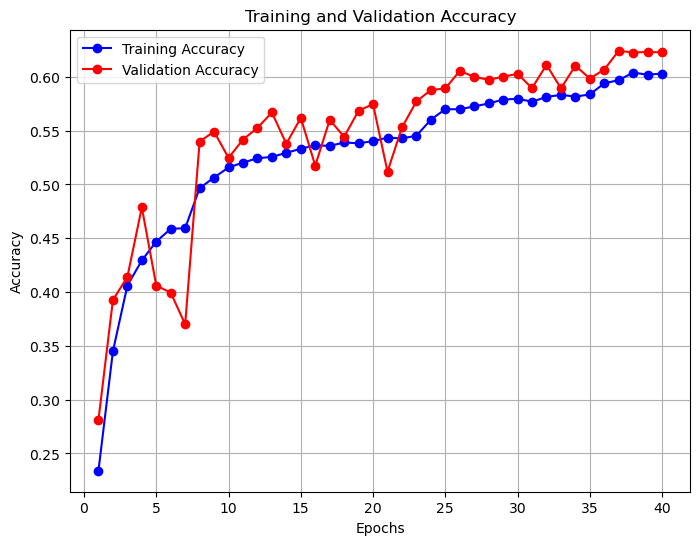

In [26]:
# Plot training accuracy
plot_training_history(history)

In [27]:
# Test accuracy
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

221/221 [==============================] - 3s 11ms/step - loss: 1.1490 - accuracy: 0.6232
Test Accuracy: 62.32%


In total 4 models were run and tested. The models had the given characteristics:

Model 1:

    * 5 layers with 16, 32, 64, 128, 64 units
    * (2,2) Kernel size
    * No l2 kernel regularizer
    * Dropout of 0.5 after dense layer
    * No lerning rate modifier
    
Model 2:

    * 6 layers with 32, 64, 128, 256, 512, 256 units
    * (2,2) kernel size
    * No l2 kernel regularizer
    * Dropout of 0.5 after dense layer
    * No lerning rate modifier
    
Model 3:

    * 6 layers with 32, 64, 128, 256, 512, 256 units
    * (3,3) kernel size
    * No l2 kernel regularizer
    * Dropout of 0.5 after dense layer
    * Learning Rate modifier with factor 0.5
    
Model 4:

    * 6 layers with 32, 64, 128, 256, 512, 256 units
    * (3,3) kernel size
    * l2 kernel regularizer of 0.001
    * Dropout of 0.5 after dense layer
    * Learning Rate modifier with factor 0.5
    
Model 4 showed the best performance with 61.3% and results and code were given in the cells above.

## **Complex Model Building**

In this section a similar CNN model was created with LeakyReLu and GlobalAveragePooling2D to improve issues with any dead neurons and overfitting

In [28]:
# Clear previous model from Keras
backend.clear_session()

In [29]:
model = Sequential([
    # 1st Convolutional Block
    Conv2D(32, (3, 3), kernel_regularizer=l2(0.0005), input_shape=(128, 128, 1)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # 2nd Convolutional Block
    Conv2D(64, (3, 3), kernel_regularizer=l2(0.0005)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # 3rd Convolutional Block
    Conv2D(128, (3, 3), kernel_regularizer=l2(0.0005)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # 4th Convolutional Block
    Conv2D(256, (3, 3), kernel_regularizer=l2(0.0005)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # 5th Convolutional Block
    Conv2D(512, (3, 3), kernel_regularizer=l2(0.0005)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Global Average Pooling
    GlobalAveragePooling2D(),

    # Fully Connected Layer
    Dense(256, kernel_regularizer=l2(0.0005)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.5),

    # Output Layer
    Dense(6, activation='softmax')
])

# Compile Model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 126, 126, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 61, 61, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        2

In [30]:
# Call back parameters
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

# Learning rate dynamic modifier
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

In [31]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=40,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/40
883/883 [==============================] - 41s 45ms/step - loss: 2.4733 - accuracy: 0.2386 - val_loss: 2.2178 - val_accuracy: 0.2330
Epoch 2/40
883/883 [==============================] - 39s 44ms/step - loss: 1.9203 - accuracy: 0.3674 - val_loss: 1.7309 - val_accuracy: 0.4477
Epoch 3/40
883/883 [==============================] - 40s 45ms/step - loss: 1.7404 - accuracy: 0.4338 - val_loss: 1.6941 - val_accuracy: 0.4601
Epoch 4/40
883/883 [==============================] - 39s 44ms/step - loss: 1.6750 - accuracy: 0.4592 - val_loss: 1.6242 - val_accuracy: 0.4857
Epoch 5/40
883/883 [==============================] - 40s 45ms/step - loss: 1.6533 - accuracy: 0.4702 - val_loss: 1.5660 - val_accuracy: 0.5142
Epoch 6/40
883/883 [==============================] - 39s 45ms/step - loss: 1.6369 - accuracy: 0.4816 - val_loss: 1.8546 - val_accuracy: 0.3991
Epoch 7/40
883/883 [==============================] - 40s 45ms/step - loss: 1.6152 - accuracy: 0.4890 - val_loss: 1.5672 - val_accuracy:

In [32]:
# Test accuracy
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

221/221 [==============================] - 2s 10ms/step - loss: 1.1344 - accuracy: 0.6116
Test Accuracy: 61.16%


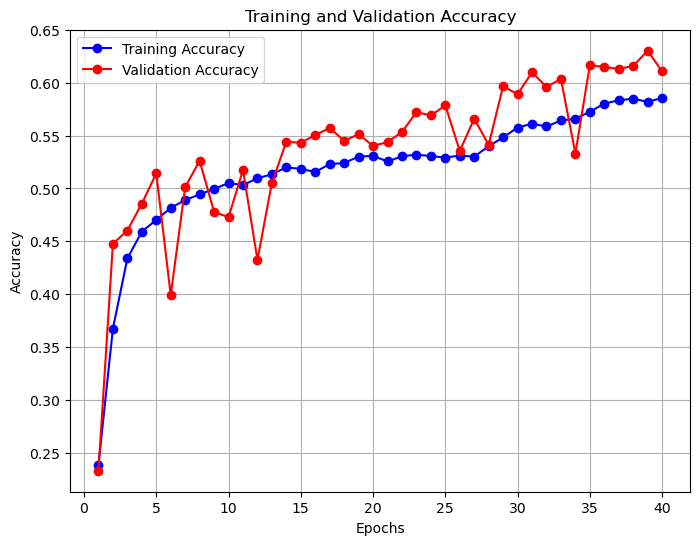

In [33]:
# Plot training accuracy
plot_training_history(history)

The model with "leaky relu" and "global average pooling" showed a slight improvement over the previous modes. It had an accuracy increase of about 4%

## **Transfer Model Building VGG16**

In this section the transfer model based on VGG16 was created, tuned, and optimized

In [34]:
# Clear previous model from Keras
backend.clear_session()

In [35]:
from tensorflow.keras.applications import VGG16

# Load the VGG16 model without the top classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
for layer in base_model.layers:
    if 'block4' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

# Seting transfer layer
transfer_layer = base_model.get_layer('block4_pool').output

# Custom classification layers
x = GlobalAveragePooling2D()(transfer_layer)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(6, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [36]:
# Loading data in color mode
# Create the ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    rotation_range=30,       # Rotate images by up to 30 degrees
    width_shift_range=0.2,   # Shift images horizontally
    height_shift_range=0.2,  # Shift images vertically
    shear_range=0.2,         # Apply shearing
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Flip images horizontally
    preprocessing_function=preprocess_to_rgb  # Convert grayscale to RGB
    
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    preprocessing_function=preprocess_to_rgb
)

# Flow training images from directory
train_generator = train_datagen.flow_from_directory(
    os.path.join(path_to_zip_file, 'Data', 'train'),
    target_size=(img_height, img_width),  # Resize images
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'  # Ensure RGB images are loaded
)

# Flow testing images from directory
test_generator = test_datagen.flow_from_directory(
    os.path.join(path_to_zip_file, 'Data', 'train'),
    target_size=(img_height, img_width),  # Resize images
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'  # Ensure RGB images are loaded
)

Found 28273 images belonging to 6 classes.
Found 28273 images belonging to 6 classes.


In [37]:
# Call back parameters
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Learning rate dynamic modifier
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

In [38]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=50,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
883/883 [==============================] - 158s 177ms/step - loss: 3.6758 - accuracy: 0.3097 - val_loss: 2.4911 - val_accuracy: 0.3961
Epoch 2/50
883/883 [==============================] - 155s 176ms/step - loss: 2.0371 - accuracy: 0.4384 - val_loss: 1.6525 - val_accuracy: 0.5139
Epoch 3/50
883/883 [==============================] - 155s 176ms/step - loss: 1.6009 - accuracy: 0.4967 - val_loss: 1.4630 - val_accuracy: 0.5339
Epoch 4/50
883/883 [==============================] - 155s 175ms/step - loss: 1.4082 - accuracy: 0.5337 - val_loss: 1.2415 - val_accuracy: 0.5922
Epoch 5/50
883/883 [==============================] - 156s 177ms/step - loss: 1.2966 - accuracy: 0.5565 - val_loss: 1.1968 - val_accuracy: 0.5789
Epoch 6/50
883/883 [==============================] - 155s 175ms/step - loss: 1.2260 - accuracy: 0.5750 - val_loss: 1.1061 - val_accuracy: 0.6141
Epoch 7/50
883/883 [==============================] - 157s 178ms/step - loss: 1.1647 - accuracy: 0.5919 - val_loss: 1.0254 -

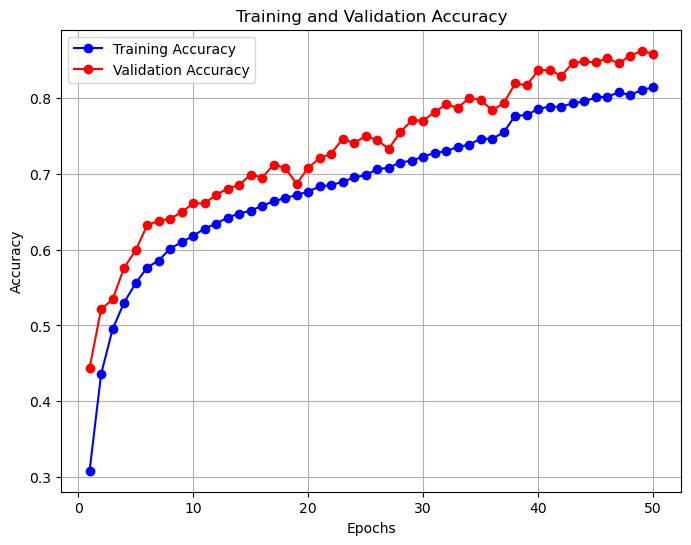

In [110]:
# Plot training accuracy
plot_training_history(history)

In [105]:
# Test accuracy
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

884/884 [==============================] - 30s 33ms/step - loss: 0.4518 - accuracy: 0.8581
Test Accuracy: 85.81%


In total 4 models were run and tested. The models had different numbers of fully connected dense layers, different transfer layers, and different number of frozen layers. The first model tested had all VGG16 layers frozen and one dense layer with 256 units. The second model had the transfer layer set to 'block4_pool' and all of those layer were frozen. The model also had one dense layer with 256 units. The third model was had the same characteristics of model 2, but with one added dense layer with 128 units. The last model seen above maintained the previous models characteristics, but block 4 was unfrozen to allow more parameters to be trained. The last model had better performance with 85% accuracy.


## **Transfer Model Building ResNet**

In this section the transfer model based on ResNet was created, tuned, and optimized

In [120]:
# Clear previous model from Keras
backend.clear_session()

In [121]:
from tensorflow.keras.applications import ResNet50

# Load the ResNet50 model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze all layers
for layer in base_model.layers:
    if 'conv4' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

# Extract a specific layer
transfer_layer = base_model.get_layer('conv4_block6_out').output

# Custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(transfer_layer)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(6, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [122]:
# Call back parameters
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Learning rate dynamic modifier
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

In [123]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=40,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/40
883/883 [==============================] - 165s 183ms/step - loss: 3.6804 - accuracy: 0.2331 - val_loss: 2.5006 - val_accuracy: 0.2715
Epoch 2/40
883/883 [==============================] - 158s 179ms/step - loss: 2.0994 - accuracy: 0.2722 - val_loss: 2.0188 - val_accuracy: 0.1854
Epoch 3/40
883/883 [==============================] - 159s 180ms/step - loss: 1.7752 - accuracy: 0.2996 - val_loss: 1.6294 - val_accuracy: 0.3371
Epoch 4/40
883/883 [==============================] - 160s 181ms/step - loss: 1.6540 - accuracy: 0.3391 - val_loss: 1.6035 - val_accuracy: 0.3459
Epoch 5/40
883/883 [==============================] - 161s 183ms/step - loss: 1.5809 - accuracy: 0.3753 - val_loss: 1.4316 - val_accuracy: 0.4333
Epoch 6/40
883/883 [==============================] - 162s 183ms/step - loss: 1.5325 - accuracy: 0.3951 - val_loss: 1.3948 - val_accuracy: 0.4546
Epoch 7/40
883/883 [==============================] - 157s 178ms/step - loss: 1.4910 - accuracy: 0.4186 - val_loss: 1.3351 -

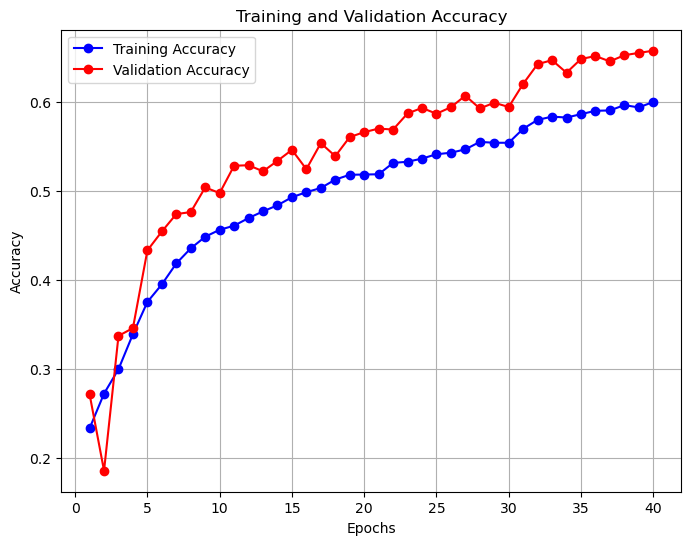

In [124]:
# Plot training accuracy
plot_training_history(history)

In [125]:
# Test accuracy
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

884/884 [==============================] - 34s 38ms/step - loss: 0.9258 - accuracy: 0.6579
Test Accuracy: 65.79%


In total 3 models were run and tested. The models had different transfer layers and different number of frozen layers. The first model tested had all blocks (except the classification block) imported. All layers were frozen. The second model had the transfer layer set to 'conv4_block6_out' and all layers were frozen. The third and last model had all convolutional blocks frozen except the last one to allow more parameters to be trained.

## **Conclusion**

Based on the tested model the VGG16 transfer learning model showed best accuracy and reliability. However, it is import to notice that this analysis is exploratory and not scientific. Due time and hardware limitation the models were not tested against a wide range of parameters. In addition, the exploration was an iteration process and not held against constant parameters across different model architectures. A study needs to be done on different transfer models holding the number of trainable and untrainable parameters constant across a wide range of values. Independent and dependent variables need to be tabulated, compared, and analyzed across different constants to have a definitive answer on the model that will better perform on our test set.